In [131]:
import os
import functools
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import lmfit

from matplotlib.ticker import MultipleLocator
from lmfit import Parameter, Parameters 

import sivqed.models.fitter as fitter
from sivqed.models.cavity import Cavity, MultiQubitCavity

np.set_printoptions(precision=4)
plt.rcParams['font.size'] = 18
plt.rcParams['figure.figsize'] = [8, 5]

In [13]:
siv_path = "../data/2021_03_03_stitched/"
prefix = "sweeper_fwd_avg_"
siv_files = []
for file in os.listdir(siv_path):
    if file.startswith(prefix) and file.endswith(".txt"):
        siv_files.append(file[len(prefix):])
        
print(siv_files)

['10_17_58.txt', '10_47_04.txt', '11_06_07.txt', '11_14_47.txt', '11_22_49.txt', '11_28_41.txt']


## Plot SiV Data

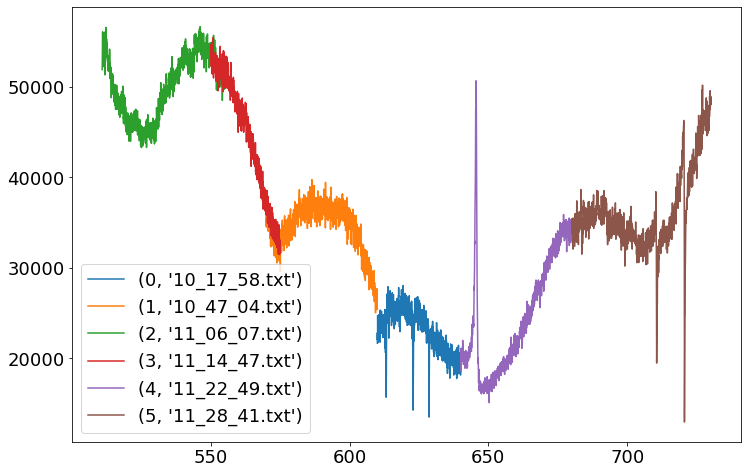

In [90]:
cavity_freqs = []
cavity_intensity = []

color = plt.cm.jet(np.linspace(0, 1, len(siv_files)))
plt.figure(figsize=[12, 8])

for i, file in enumerate(siv_files):
    freqs, intensity = np.loadtxt(siv_path + prefix + file)
    freqs = 1000 * (freqs - 406) # Re-center, convert to GHz
    plt.plot(freqs, intensity, label=(i, file))
    
    cavity_freqs.extend(freqs)
    cavity_intensity.extend(intensity)
plt.legend()

# Sort by frequency values
cavity_freqs, cavity_intensity = zip(*sorted(zip(cavity_freqs, cavity_intensity)))
cavity_freqs, cavity_intensity = np.array(cavity_freqs), np.array(cavity_intensity)

## Plot Filter ranges to remove SiV peaks

In [165]:
# Range of frequencies to filter out to remove SiV peaks
filter_range = [(612, 615), (621.5, 624.5), (627.5, 629.5), (643, 647.5), (709, 712), (718.5, 722.5)]

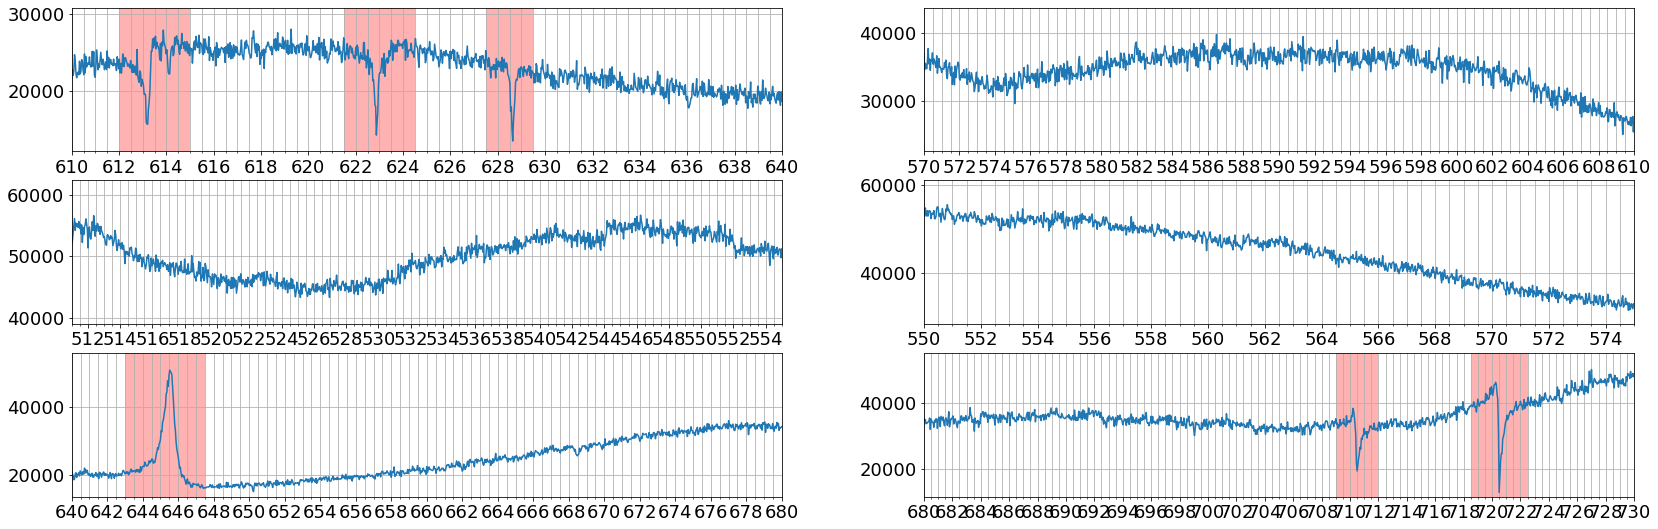

In [110]:
fig, ax = plt.subplots(figsize=[28, 9], nrows=3, ncols=2)
for i, file in enumerate(siv_files):
    axes = ax[i//2, i%2]    
    freqs, intensity = np.loadtxt(siv_path + prefix + file)
    freqs = 1000 * (freqs - 406) # Re-center, convert to GHz
    axes.plot(freqs, intensity)
    
    for start, end in filter_range:
        axes.add_patch(patches.Rectangle((start, 0), (end-start), 70000, facecolor='red', alpha=0.3))
        
    axes.set_xlim([min(freqs), max(freqs)])
    axes.set_ylim([0.9 * min(intensity), 1.1 * max(intensity)])
    
    axes.xaxis.set_major_locator(MultipleLocator(2))
    axes.xaxis.set_minor_locator(MultipleLocator(0.5))
    axes.grid(which='both')

# Fit Cavity Spectrum by filtering out SiV peaks

In [233]:
def not_in_range(arr, ranges):
    """ Returns indices of `arr` that do not lie in the list 
        of (start, end) tuples in ranges. """
    
    conditions = []
    # AND of (x < start OR x > end) leads to all x that are 
    # outside of the (start, end) ranges.
    for start, end in ranges:
        conditions.append((arr < start) | (arr > end)) 
    return np.where(functools.reduce(np.logical_and, conditions))

def in_range(arr, ranges):
    """ Returns indices of `arr` that lie in any of the list 
        of (start, end) tuples in ranges. """
    
    conditions = []
    # OR of (x >= start AND x <= end) leads to all x that are 
    # inside of any (start, end) range.
    for start, end in ranges:
        conditions.append((arr >= start) & (arr <= end)) 
    return np.where(functools.reduce(np.logical_or, conditions))

Text(0.5, 1.0, 'Filtered cavity spectrum')

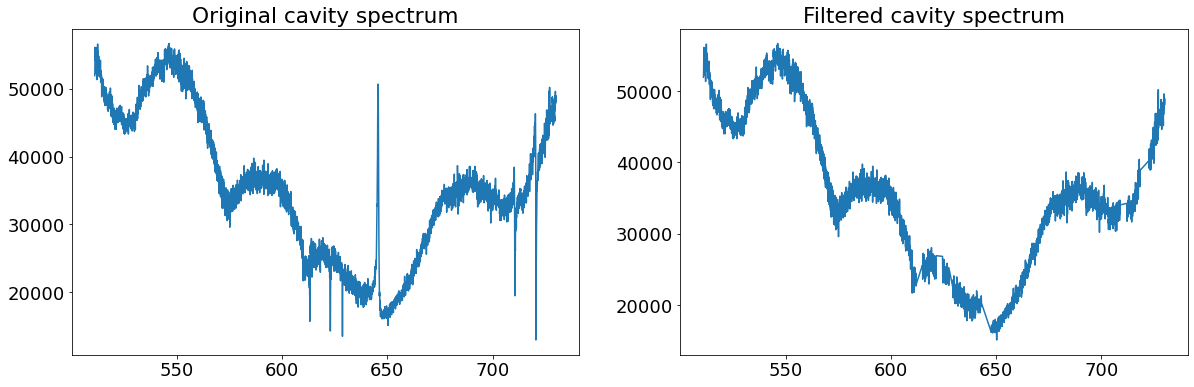

In [169]:
filtered_indices = not_in_range(cavity_freqs, filter_range)
cavity_freqs_filtered = cavity_freqs[filtered_indices]
cavity_intensity_filtered = cavity_intensity[filtered_indices]

fig, ax = plt.subplots(figsize=[20, 6], ncols=2)
ax[0].plot(cavity_freqs, cavity_intensity)
ax[0].set_title("Original cavity spectrum")
ax[1].plot(cavity_freqs_filtered, cavity_intensity_filtered)
ax[1].set_title("Filtered cavity spectrum")

## Fit cavity function to filtered cavity scan

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 620
    # data points      = 5487
    # variables        = 5
    chi-square         = 9.3645e+10
    reduced chi-square = 17082300.5
    Akaike info crit   = 91383.0454
    Bayesian info crit = 91416.0960
##  Warning: uncertainties could not be estimated:
[[Variables]]
    w_c:    642.850688 (init = 650)
    k_in:   53.4769982 (init = 100)
    k_tot:  67.6186776 (init = 100)
    A:      60391.3534 (init = 40000)
    B:      7.06980682 (init = 0.1)


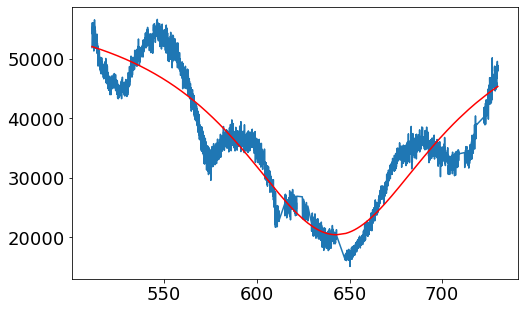

In [225]:
params = Parameters()
params.add_many(
    Parameter('w_c', value=650, min=640, max=660),
    Parameter('k_in', value=100, min=0, max=1000),
    Parameter('k_tot', value=100, min=0, max=1000),
    Parameter('A', value=40000, min=0, max=70000),
    Parameter('B', value=0.1, min=0, max=1000),
)

results = fitter.fit_reflection(params, cavity_freqs_filtered, cavity_intensity_filtered, fit_func=fitter.cavity_ref)
lmfit.report_fit(results)

plt.plot(cavity_freqs_filtered, cavity_intensity_filtered)
plt.plot(cavity_freqs_filtered, cavity_intensity_filtered + results.residual, 'r')

fit_ratio = cavity_intensity_filtered / (cavity_intensity_filtered + results.residual)

### Fit sinusoidal to fitted cavity ratio

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 52
    # data points      = 5487
    # variables        = 4
    chi-square         = 40.3783553
    reduced chi-square = 0.00736428
    Akaike info crit   = -26943.2828
    Bayesian info crit = -26916.8423
[[Variables]]
    w:    0.14032040 +/- 3.0339e-04 (0.22%) (init = 0.125)
    phi:  6.27999999 +/- 0.01237731 (0.20%) (init = 2)
    A:    0.09371536 +/- 0.00160262 (1.71%) (init = 0.2)
    B:    1.00210097 +/- 0.00117315 (0.12%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(w, phi) = -0.995
    C(phi, B) =  0.148
    C(w, B)   = -0.143


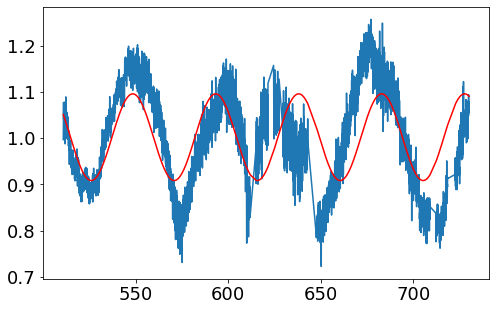

In [224]:
def fit_sin(params, x, spectrum):
    params = params.valuesdict()
    return params["A"] * np.sin(params["w"] * x - params["phi"]) + params["B"] - spectrum

params_ratio = Parameters()
params_ratio.add_many(
    Parameter('w', value=0.125, min=0.08, max=0.18),
    Parameter('phi', value=2, min=0, max=6.28),
    Parameter('A', value=0.2, min=0, max=0.5),
    Parameter('B', value=1, min=0, max=2),
)
ratio_results = fitter.fit_reflection(params_ratio, cavity_freqs_filtered, fit_ratio, fit_func=fit_sin)
lmfit.report_fit(ratio_results)

plt.plot(cavity_freqs_filtered, fit_ratio)
plt.plot(cavity_freqs_filtered, fit_ratio + ratio_results.residual, 'r')

### Fit bounced sinusoidal to fitted cavity ratio

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 78
    # data points      = 5487
    # variables        = 5
    chi-square         = 22.0032870
    reduced chi-square = 0.00401373
    Akaike info crit   = -30272.4517
    Bayesian info crit = -30239.4010
[[Variables]]
    w:     0.12045014 +/- 3.3904e-04 (0.28%) (init = 0.125)
    xref:  613.876494 +/- 0.08260176 (0.01%) (init = 620)
    phi:   5.3979e-08 +/- 0.01871633 (34673493.30%) (init = 3.1)
    A:     0.12422510 +/- 0.00119169 (0.96%) (init = 0.2)
    B:     0.99381865 +/- 8.6293e-04 (0.09%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(w, phi) = -0.867


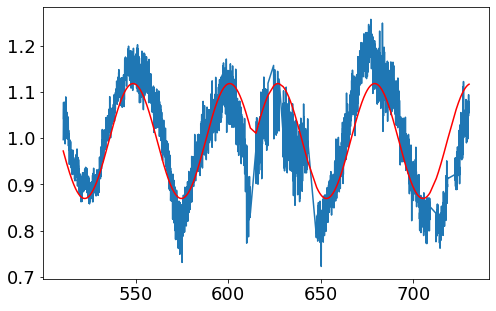

In [223]:
def fit_bounce_sin(params, x, spectrum):
    params = params.valuesdict()
    return params["A"] * np.sin(params["w"] * np.abs(x - params["xref"]) - params["phi"]) + params["B"] - spectrum

params_ratio = Parameters()
params_ratio.add_many(
    Parameter('w', value=0.125, min=0.08, max=0.18),
    Parameter('xref', value=620, min=610, max=630),
    Parameter('phi', value=3.1, min=0, max=6.28),
    Parameter('A', value=0.2, min=0, max=0.5),
    Parameter('B', value=1, min=0, max=2),
)
ratio_results = fitter.fit_reflection(params_ratio, cavity_freqs_filtered, fit_ratio, fit_func=fit_bounce_sin)
lmfit.report_fit(ratio_results)

plt.plot(cavity_freqs_filtered, fit_ratio)
plt.plot(cavity_freqs_filtered, fit_ratio + ratio_results.residual, 'r')

## "Fit" cavity function using previously-fit kappas

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 136
    # data points      = 5487
    # variables        = 3
    chi-square         = 4.6007e+11
    reduced chi-square = 83892813.8
    Akaike info crit   = 100113.591
    Bayesian info crit = 100133.422
##  Warning: uncertainties could not be estimated:
    w_c:    at boundary
    A:      at boundary
    B:      at boundary
[[Variables]]
    w_c:    660.000000 (init = 650)
    k_in:   126.3889 (fixed)
    k_tot:  164.0927 (fixed)
    A:      69999.9964 (init = 40000)
    B:      999.999949 (init = 0.1)


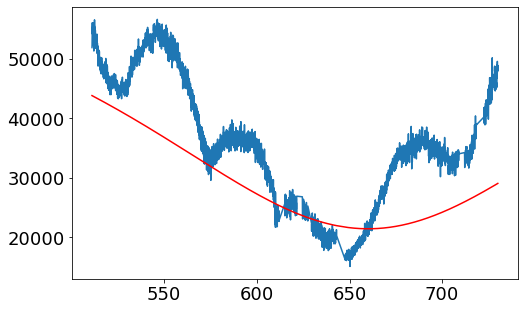

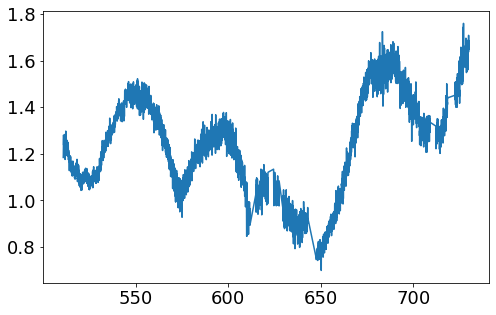

In [216]:
params = Parameters()
params.add_many(
    Parameter('w_c', value=650, min=640, max=660),
    Parameter('k_in', value=126.3889, vary=False),
    Parameter('k_tot', value=164.092706, vary=False),
    Parameter('A', value=40000, min=0, max=70000),
    Parameter('B', value=0.1, min=0, max=1000),
)
#     k_in:   124.675367 +/- 2221517.43 (1781841.49%) (init = 100)
#     k_tot:  159.399874 +/- 9.07243447 (5.69%) (init = 100)
#     -------------------------------------------------------------
#     k_in:   37.7011050 +/- 9753600.40 (25870860.84%) (init = 100)
#     k_tot:  164.092706 +/- 4.54734643 (2.77%) (init = 100)

results = fitter.fit_reflection(params, cavity_freqs_filtered, cavity_intensity_filtered, fit_func=fitter.cavity_ref)
lmfit.report_fit(results)

plt.plot(cavity_freqs_filtered, cavity_intensity_filtered)
plt.plot(cavity_freqs_filtered, cavity_intensity_filtered + results.residual, 'r')

plt.figure()
plt.plot(cavity_freqs_filtered, cavity_intensity_filtered / (cavity_intensity_filtered + results.residual))

# Fit SiV Spectrum

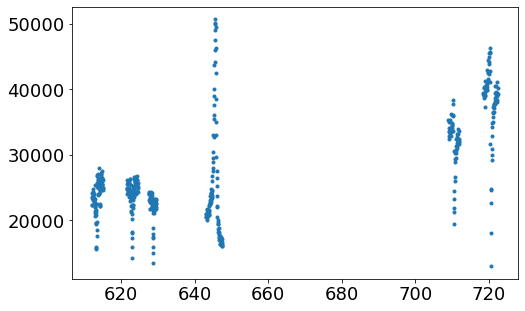

In [245]:
siv_indices = in_range(cavity_freqs, filter_range)
cavity_freqs_siv = cavity_freqs[siv_indices]
cavity_intensity_siv = cavity_intensity[siv_indices]

plt.plot(cavity_freqs_siv, cavity_intensity_siv, '.')

## Fitting SiV index 4

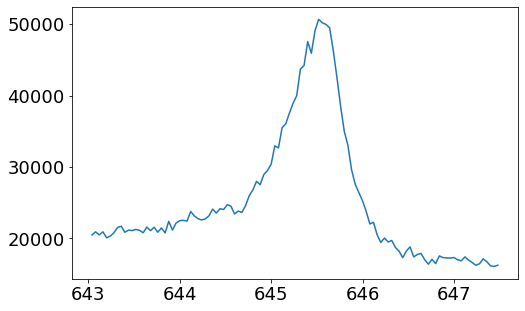

In [252]:
cavity_freqs_siv_4 = cavity_freqs_siv[(cavity_freqs_siv > 640) & (cavity_freqs_siv < 660)]
cavity_intensity_siv_4 =cavity_intensity_siv[(cavity_freqs_siv > 640) & (cavity_freqs_siv < 660)]

plt.plot(cavity_freqs_siv_4, cavity_intensity_siv_4)

### Fix gamma

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 478
    # data points      = 112
    # variables        = 6
    chi-square         = 53893667.4
    reduced chi-square = 508430.824
    Akaike info crit   = 1477.41076
    Bayesian info crit = 1493.72176
[[Variables]]
    w_up:      645.592227 +/- 0.00516979 (0.00%) (init = 645.5)
    g_up:      8.24390883 +/- 6.02107955 (73.04%) (init = 5.6)
    gamma_up:  0.1 (fixed)
    w_c:       623.288199 +/- 31.9144513 (5.12%) (init = 642)
    k_in:      199.999975 +/- 175.879596 (87.94%) (init = 100)
    k_tot:     296.067035 +/- 432.807453 (146.19%) (init = 150)
    A:         143788.126 +/- 3130.38373 (2.18%) (init = 6000)
    B:         0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(k_in, k_tot) =  1.000
    C(g_up, k_in)  =  1.000
    C(g_up, k_tot) =  1.000
    C(w_c, k_in)   = -1.000
    C(g_up, w_c)   = -1.000
    C(w_c, k_tot)  = -1.000
    C(w_up, g_up)  = -0.605
    C(w_up, k_in)  = -0

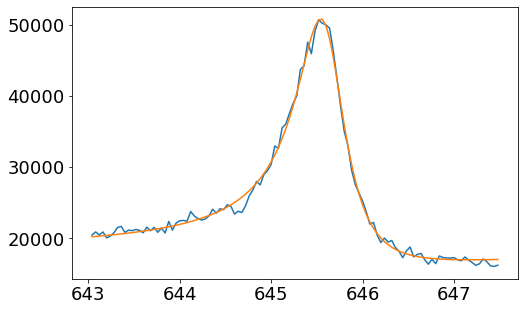

In [251]:
params = Parameters()
params.add_many(
    Parameter('w_up', value=645.5, min=645, max=646),
    Parameter('g_up', value=5.6, min=1, max=20),
    Parameter('gamma_up', value=0.1, vary=False),
    Parameter('w_c', value=642, min=0, max=1000),
    Parameter('k_in', value=100, min=0, max=200),
    Parameter('k_tot', value=150, min=0, max=300),
    Parameter('A', value=6000, min=5000, max=900000),
    Parameter('B', value=0, vary=False),
)

results = fitter.fit_reflection(params, cavity_freqs_siv_4, cavity_intensity_siv_4, fit_func=fitter.single_siv_ref)
lmfit.report_fit(results)

plt.plot(cavity_freqs_siv_4, cavity_intensity_siv_4)
plt.plot(cavity_freqs_siv_4, cavity_intensity_siv_4 + results.residual)

### Fix total kappa

In [253]:
# params = Parameters()
# params.add_many(
#     Parameter('w_up', value=645, min=644, max=646),
#     Parameter('g_up', value=5.6, min=1, max=20),
#     Parameter('gamma_up', value=0.1, min=0, max=5),
#     Parameter('w_c', value=715, min=0, max=1000),
#     Parameter('k_in', value=100, min=0, max=200),
#     Parameter('k_tot', value=159.38, vary=False),
#     Parameter('A', value=6000, min=5000, max=900000),
#     Parameter('B', value=0.1, min=0, max=1000),
# )

# results = fitter.fit_reflection(params, siv_freqs, siv_mean, fit_func=fitter.single_siv_ref)
# lmfit.report_fit(results)

# plt.plot(siv_freqs, siv_mean)
# plt.plot(siv_freqs, siv_mean + results.residual)

### Fix total kappa, gamma

In [254]:
# params = Parameters()
# params.add_many(
#     Parameter('w_up', value=645, min=644, max=646),
#     Parameter('g_up', value=5.6, min=1, max=20),
#     Parameter('gamma_up', value=0.1, vary=False),
#     Parameter('w_c', value=715, min=0, max=1000),
#     Parameter('k_in', value=100, min=0, max=200),
#     Parameter('k_tot', value=159.38, vary=False),
#     Parameter('A', value=6000, min=5000, max=900000),
#     Parameter('B', value=0.1, min=0, max=1000),
# )

# results = fitter.fit_reflection(params, siv_freqs, siv_mean, fit_func=fitter.single_siv_ref)
# lmfit.report_fit(results)

# plt.plot(siv_freqs, siv_mean)
# plt.plot(siv_freqs, siv_mean + results.residual)

# Bulk SiV Fitting

In [4]:
def bulk_fit_siv(params, plot_fits=True):
    
    if plot_fits:
        plt.figure(figsize=[24, 20])   

    fit_params = defaultdict(list)
    fit_params_errors = defaultdict(list)
    reduced_chi = []

    for idx, file in enumerate(siv_files):
        # Get the SiV Data
        siv_data = np.loadtxt(siv_path + file)
        if len(siv_data.shape) == 1: siv_data = siv_data.reshape(1, len(siv_data))
        siv_mean = np.sum(siv_data, axis=0) / len(siv_data)

        # Extract SiV frequency axis
        siv_data_avg = np.loadtxt(siv_path.replace("scans", "avg") + file)
        siv_freqs = 1000 * (siv_data_avg[0] - 406)

        # Perform fit
        results = fitter.fit_reflection(params, siv_freqs, siv_mean, fit_func=fitter.single_siv_ref)

        # Store fit results
        for param, param_results in results.params.items():
            if not param_results.vary: continue
            fit_params[param].append(param_results.value)
            fit_params_errors[param].append(param_results.stderr)
        reduced_chi.append(results.redchi)
        
        if plot_fits:
            plt.subplot(4, 3, idx+1)
            plt.plot(siv_freqs, siv_mean)
            plt.plot(siv_freqs, siv_mean + results.residual)
        
    # Plot fit results
    plt.figure(figsize=[32, 10])   
    for idx, (param, param_fit) in enumerate(fit_params.items()):
        plt.subplot(2, 4, idx+1)
        x_axis = range(len(param_fit))
        errors = [err if err is not None else 0 for err in fit_params_errors[param]]
        plt.bar(x_axis, param_fit, yerr=errors)
        plt.title(param)
        plt.gca().relim() # Ignore error bar scales

    plt.subplot(2, 4, idx+2)
    plt.bar(range(len(reduced_chi)), reduced_chi)
    plt.title("Reduced $\chi^2$")
    
    return fit_params, fit_params_errors, reduced_chi

In [255]:
# params = Parameters()
# params.add_many(
#     Parameter('w_up', value=645, min=644, max=646),
#     Parameter('g_up', value=5.6, min=1, max=20),
#     Parameter('gamma_up', value=0.1, min=0, max=5),
#     Parameter('w_c', value=715, min=0, max=1000),
#     Parameter('k_in', value=100, min=0, max=200),
#     Parameter('k_tot', value=159.38, vary=False),
#     Parameter('A', value=6000, min=5000, max=900000),
#     Parameter('B', value=0.1, min=0, max=1000),
# )
# fit_params, fit_params_errors, reduced_chi = bulk_fit_siv(params)